In [86]:
# define libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TransformerConv
from torch.nn import LSTM
import matplotlib.pyplot as plt
import numpy as np

In [87]:
# SET Parameters

# define the number of nodes
node_num = 11

# define the number of features
feature_num = 3

# DAILY
start_col = 1

# HOURLY
# start_col = 2

# define the number of time steps
time_step = 3

# torch seed
torch.manual_seed(12345)

index = 0

# Learning rate
learning_rate = 0.001

title = f'LR={learning_rate};'

# Loss function
loss_function = 0 # MSE
loss_function = 1 # MAPE

if loss_function == 0:
    title += 'MSE;'
else: title += 'MAPE;'

# have L2 regularization
l2 = False
l2R = 0.005

if l2:
    title+= f'with L2R={l2R}'



In [88]:
torch.manual_seed(200)

In [89]:
# read from dataset of csv files
import pandas as pd

dataset = []

for i in range(node_num):
    dataset.append(pd.read_csv('Dataset/cleaned_data_' + str(i) + '.csv'))

print(dataset[0].iloc[:, start_col: start_col + feature_num].values)

[[ 1.28797907  1.76169988 20.56032089]
 [ 0.7353602   2.61792223 21.318358  ]
 [ 0.66649559  1.93931207 19.22493963]
 ...
 [ 2.2929719   4.12523203 44.98559097]
 [ 0.91600953  3.86341212 40.89374369]
 [ 0.73398368  3.48193701 31.75835918]]


In [90]:
# Check for NaN in pd dataframe then print row
for i in range(node_num):
    print(f'{i}:', dataset[i].isnull().values.any())
    # print(dataset[i].isnull().sum())

0: False
1: False
2: False
3: False
4: False
5: False
6: False
7: False
8: False
9: False
10: False


In [91]:
print(len(dataset))
print(dataset[0].shape)

11
(1095, 4)


In [92]:
print(dataset[0].iloc[:, start_col:].values)
# convert datasets to list
for i in range(node_num):
    dataset[i] = dataset[i].iloc[:, start_col:].values.tolist()

[[ 1.28797907  1.76169988 20.56032089]
 [ 0.7353602   2.61792223 21.318358  ]
 [ 0.66649559  1.93931207 19.22493963]
 ...
 [ 2.2929719   4.12523203 44.98559097]
 [ 0.91600953  3.86341212 40.89374369]
 [ 0.73398368  3.48193701 31.75835918]]


In [93]:
data = torch.tensor(dataset, dtype=torch.float)
print(data.shape)

edges = [[], []]
for i in range(node_num):
    for j in range(node_num):
        edges[0].append(i)
        edges[1].append(j)

edge_index = torch.tensor(edges)

torch.Size([11, 1095, 3])


In [94]:
# # Base model
# from torch_geometric_temporal import GConvGRU

# in_channel = feature_num * time_step
# out_channel = 1

# k = 3

# # define model
# model = GConvGRU(in_channel, out_channel, k)

In [95]:
# Define your GCNConv layer with 3 input features and 12 output features
# input features are n*m matrix, n is the number of nodes, m is the number of features
gcn1 = GCNConv(feature_num * time_step, 6 * feature_num)

gcn2 = GCNConv(6 * feature_num, 6 * feature_num)

gcn3 = GCNConv(6 * feature_num, 6 * feature_num)

# gcn3 = GCNConv(node_num * 4, node_num * 4)

# Define your TransformerConv layer with 12 input features and 3 output features:
transformer1 = TransformerConv(6 * feature_num, 1, heads= 3 * feature_num, dropout=0.3)
transformer2 = TransformerConv(3 * feature_num, 1, heads= 1, dropout=0.3)


# Define your model architecture:
class MyModel(torch.nn.Module):
    weight =[]
    def __init__(self, gcn1, gcn2, gcn3, transformer1, transformer2):
        super(MyModel, self).__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
        self.gcn3 = gcn3
        self.transformer1 = transformer1
        self.transformer2 = transformer2


    def forward(self, x, edge_index):
 
        x = self.gcn1(x, edge_index)
        # print(x.shape)
        # res1 = F.relu(res1)
        # x = x.view(-1, x.size(-1))

        x = self.gcn2(x, edge_index)
        # x = self.gcn3(x, edge_index)
        # x = F.relu(x)

        # x = self.gcn3(x, edge_index)
        # x = F.relu(x)

        # x = x.view(-1, x.size(-1))

        x = self.transformer1(x, edge_index)
        # res2 = F.relu(res2)
        # combine res1 and res2, with size
        # size: 2*feature and 2*feature 
        # x = torch.cat((res1, res2), 1)

        x = self.transformer2(x, edge_index)
        # x = F.relu(x)
        return x

    
# Instantiate your model:
model = MyModel(gcn1, gcn2, gcn3, transformer1, transformer2)




In [96]:
# gcn1 = GCNConv(num_hours * num_features, num_features)
# transformer= TransformerConv(num_hours * num_features, 1, heads=num_features, dropout=0.3)
# # lstm = LSTMAggregation(12, 3)
# lstm = LSTM(12,3) # lstm layer with 3 input features and 3 output features


# # Define your model architecture:
# class MyModel(torch.nn.Module):
#     def __init__(self, gcn , lstm):
#         super(MyModel, self).__init__()
#         self.gcn = gcn
#         self.lstm = lstm

#     def forward(self, x, edge_index):
#         # Apply the gcn layer
#         x = self.gcn(x, edge_index)
#         # Apply the fully connected layer
#         # x, _ = self.lstm(x)
#         return x
    
# # Instantiate your model:
# model = MyModel(gcn1, lstm)

In [97]:
# loss function with L2 regularization
# def loss_fn(y_pred, y_true):
#     losses = []
#     mean_losses = []
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())


#     for i in range(node_num):
#         loss = []
#         for j in range(num_features):
#             error = torch.mean(torch.abs((y_true[i][j] - y_pred[i][j]) / y_true[i][j])) * 100
#             # error = F.mse_loss(y_pred[i][j], y_true[i][j]) + 0.001 * l2_norm
#             loss.append(error)
#         losses.append(loss)
    
#     for i in range(num_features):
#         mean_loss = torch.mean(torch.tensor(losses)[:, i])
#         mean_losses.append(mean_loss)

#     return losses, mean_losses


# # Define your optimizer:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [98]:
# calculate MAPE: mean absolute percentage error
def MAPE_torch(y_true, y_pred):
    return torch.abs((y_true - y_pred) / y_true) * 100

In [99]:
# for p in model.parameters():
#     print(p)

In [100]:
# loss function with L2 regularization
def loss_fn(y_pred, y_true, index, loss_function, l2, l2R=0.005):
    
    losses = 0
    l2_norm = 0
    
    if l2:
        l2_norm = sum(p.pow(2.0).sum()
                  for p in model[index].parameters())
        
    if loss_function == 0:
        losses = torch.nn.functional.mse_loss(y_pred, y_true) + l2R * l2_norm
    else:
        losses = torch.mean(MAPE_torch(y_true, y_pred)) + l2R * l2_norm

    return losses
    # losses = []
    # y_pred = y_pred.transpose(0, 1)
    # y_true = y_true.transpose(0, 1)

    # for i in range(feature_num):
    #     # losses.append(torch.mean(MAPE_torch(y_true[i], y_pred[i])) * 10 + 0.005 * l2_norm) 
    #     losses.append(torch.nn.functional.mse_loss(y_pred[:, i], y_true[:, i]) + 0.005 * l2_norm)


# Define your optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [101]:
print(data[:, 1:5, :].shape)

torch.Size([11, 4, 3])


In [102]:
# train
# y_preds = [[] for j in range(feature_num)]
y_preds = []

epoch_num = (3 * int(data.shape[1] / 4))
print(epoch_num)

# train_loss = [[] for j in range(feature_num)]
train_loss = []

# Train your model:
for epoch in range(epoch_num):
    
    row = data[:, epoch: epoch + time_step, :].reshape(-1, feature_num * time_step)
    # print(row.shape)
    # break

    losses = []


    # Set your model to train mode:
    model.train()

    # Zero the gradients:
    optimizer.zero_grad()

    # Make predictions
    y_pred = model.forward(row, edge_index)
    y_preds.append(y_pred)

    # Calculate loss
    loss = loss_fn(y_pred, data[:, epoch + time_step, index], i, loss_function, l2, l2R)
    loss.backward(retain_graph=True)

    train_loss.append(loss)

    # Optimizer
    optimizer.step()


    # # add y_pred to y_preds
    # y_preds.append(y_pred)
        

    # Print loss every 200 epochs:
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Losses:")
        # print(y_pred)
        # for i in range(feature_num):
        print(f'     ', loss)


819
Epoch 0, Losses:
      tensor(1121.8088, grad_fn=<AddBackward0>)
Epoch 200, Losses:
      tensor(206.1694, grad_fn=<AddBackward0>)
Epoch 400, Losses:
      tensor(229.7664, grad_fn=<AddBackward0>)
Epoch 600, Losses:
      tensor(39.0844, grad_fn=<AddBackward0>)
Epoch 800, Losses:
      tensor(489.6590, grad_fn=<AddBackward0>)


In [103]:
# test
# for test we give the application information of 3 hours and then predict the next one
# test_loss = [[] for j in range(feature_num)]
test_loss = []

for epoch in range(epoch_num, data.shape[1] - time_step):

    row = data[:, epoch: epoch + time_step, :].reshape(-1, feature_num * time_step)

    # Set model to evaluation mode:
    model.eval()

    # Zero the gradients:
    optimizer.zero_grad()

    # Make predictions
    y_pred = model.forward(row, edge_index)
    y_preds.append(y_pred)

    # Calculate loss
    loss = loss_fn(y_pred, data[:, epoch + time_step, index], i, loss_function, l2, l2R)
    test_loss.append(loss)

    # # add y_pred to y_preds
    # y_preds.append(y_pred)
    

    # Print loss every 200 epochs:
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Losses:")
        # print(y_pred)
        # for i in range(feature_num):
        print(f'     ', loss)

Epoch 1000, Losses:
      tensor(65.2563, grad_fn=<AddBackward0>)


In [104]:
len(y_preds[0])

11

In [106]:
y_true = data[:, :data.shape[1] - time_step, index].reshape(-1, node_num).detach().numpy()

y_preds_ = torch.stack(y_preds).reshape(-1, node_num).detach().numpy()

y_preds_ = np.array(y_preds_)
print(y_preds_.shape)
print(y_true.shape)

# # mean on third col
y_preds_ = np.mean(y_preds_, axis=1)
y_true_ = np.mean(y_true, axis=1)

(1092, 11)
(1092, 11)


In [108]:
y_preds_.shape

(1092,)

LR=0.001;MAPE;


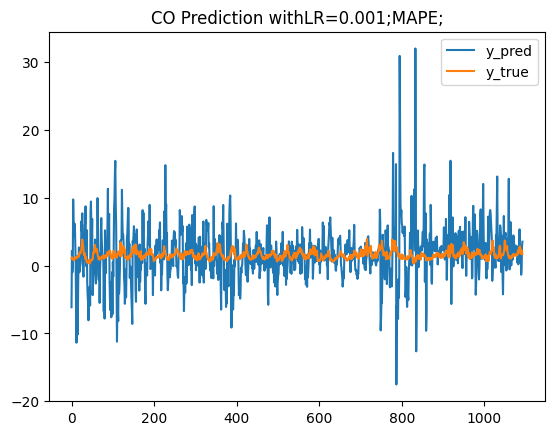

In [109]:
x = np.linspace(0, y_preds_.shape[0], y_preds_.shape[0])
plt.title(f'CO Prediction with' + title)
print(title)
plt.plot(x, y_preds_, label='y_pred')
plt.plot(x, y_true_, label='y_true')
plt.legend()

In [110]:
# change type of whole_loss list of tensors to numpy array

# whole_loss = [[] for j in range(feature_num)]
# for i in range(feature_num):
#     train_loss[i] = torch.stack(train_loss[i]).detach().numpy()
#     test_loss[i] = torch.stack(test_loss[i]).detach().numpy()

#     # whole loss = concatination of whole loss and test loss
#     whole_loss[i] = np.concatenate((train_loss[i], test_loss[i]), axis=0)

whole_loss = []
train_loss = torch.stack(train_loss).detach().numpy()
test_loss = torch.stack(test_loss).detach().numpy()

# whole loss = concatination of whole loss and test loss
whole_loss = np.concatenate((train_loss, test_loss), axis=0)

In [112]:
len(whole_loss)

1092

69.74239


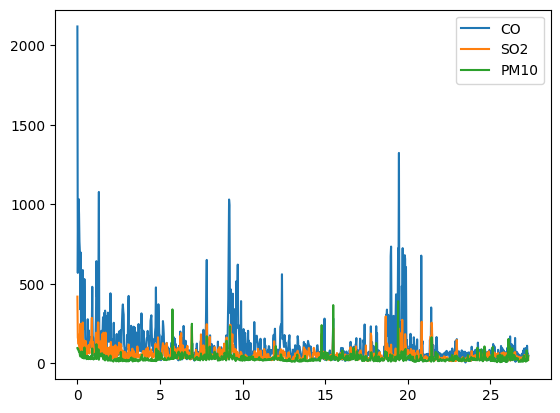

In [ ]:
# plot the loss curve

# concat

# plt.plot(whole_loss[0], label='CO')


# import numpy as np
# print(np.mean(whole_loss[0]))
# print(np.mean(whole_loss[1]))
# print(np.mean(whole_loss[2]))
x = np.linspace(0, len(whole_loss[1])/40, len(whole_loss[1]))

plt.plot(x, whole_loss[0], label='CO')
plt.plot(x, whole_loss[1], label='SO2')
plt.plot(x, whole_loss[2], label='PM10')
print(np.mean(whole_loss))
plt.legend(loc='best')
plt.show()

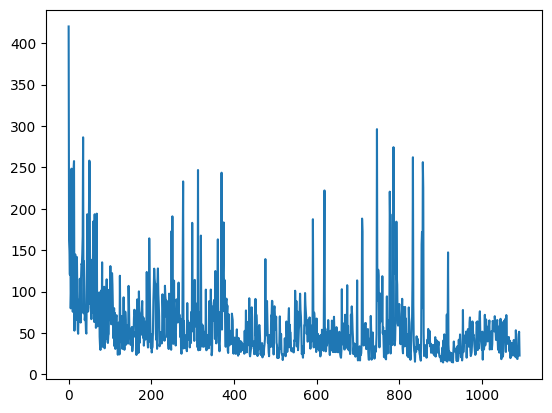

In [ ]:
plt.plot(whole_loss[1], label='SO2')

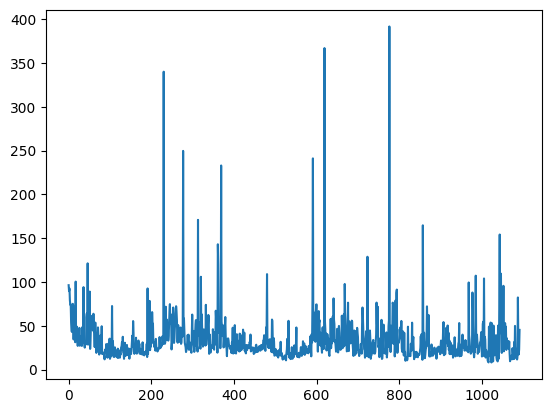

In [ ]:
plt.plot(whole_loss[2], label='PM10')

In [ ]:
# calculate MAPE: mean absolute percentage error
def MAPE(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true) * 100

num_data = len(y_preds)

mapes_train = [[] for j in range(feature_num)]
mapes_test = [[] for j in range(feature_num)]
# mapes = [[] for j in range(feature_num)]
mapes = []
for i in range(num_data):

    y_true = data[:, i, :].detach().numpy()
    y_true = y_true.transpose()
    # print(y_true.shape)

    y_pred = y_preds[i].detach().numpy()
    y_pred = y_pred.transpose()
    # print(y_pred.shape)

    mape = MAPE(y_true, y_pred)

    # print(mape.shape)

    # for i in range(feature_num):
    #     mapes[i].append(np.mean(mape[i]))
    mapes.append(mape)
    # print(mapes[0])

print(np.mean(mapes))
# print(mapes[0][12000])

# output = []  
# for i in range(feature_num):
#     output.append(np.mean(mapes[i]))

# print(output)



AttributeError: 'list' object has no attribute 'detach'

[46.44375, 64.463326, 71.33586] # MAPE of GCN-Transformer


[35.568245, 54.249947, 62.4942] # MAPE of GCN


[26.197187, 30.585236, 32.938267] # MAPE of Transformer

In [ ]:
# r2 score
from sklearn.metrics import r2_score
x = data.view(-1, node_num, feature_num)
x = x[1:, :, :]
# print(x.shape)
x = x.view(-1, num_data)
print(x.shape)
x = x.detach().numpy()
y = torch.stack(y_preds).view(-1, num_data)
print(y.shape)
y = y.detach().numpy()

r2 = torch.zeros(num_data)
for i in range(num_data):
    r2[i] = r2_score(x[:, i], y[:, i])

plt.plot(r2, label='r2')
print(sum(r2)/num_data)

RuntimeError: shape '[-1, 1092]' is invalid for input of size 36102